<a href="https://colab.research.google.com/github/TheBlondMyth/AlgoTrading/blob/main/NB1.2_Overfitting_and_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning using noisy data: overfitting and validation


---


This notebook covers another simple deep learning problem similar to the one in NB 1.1, except we now add noises to the observed data.

In this example, we assume the true relationship between feature $x$ and label $y$ is
\begin{align}
y=f(x)=10x - x^2
\end{align}
We generate $N$ samples of data $(x^i,y^i)$ as follows:

1.   Create a list of $N$ feature values via $x^i:=10(i-1)/(N-1)$ for $i=1,...,N$ such that $x^i$'s are $N$ uniformly-spaced numbers in $[0,10]$.
2.   Generate values of the label $y^i$ via
\begin{align}
y^i=f(x^i)+\epsilon^i \qquad \text{for }i=1,...,N
\end{align}
where $\epsilon^i\sim N(0,\eta^2)$ are i.i.d. Gaussian random variables with mean zero and standard deviation $\eta$.

We will construct two deep learning models: a "simple" one and a "complex" one. Then we will compare their fitting performance.


---



# Demonstration of overfitting

As before, we first import the standard packages as follows.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Then we generate the data using the previously described procedures. Note that we have fixed the random seed by the command "np.random.seed(123)" and "tf.random.set_seed(123)". Whenever random simulation is involved, it is usually a good practice to do so to ensure the program is generating the same random outcomes on each run which facilitates reproducibility of the outputs.

The number of data points is chosen to be $N=200$ (intentionally chosen to be a small number for better illustration) and the standard deviation of the noise is $\eta=2$.

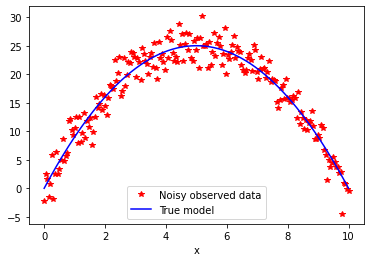

In [ ]:
N = 200
eta = 2
np.random.seed(123)
tf.random.set_seed(123)

obs_x = np.linspace(0, 10, N)                 # create an array of N elements ranging from 0 to 10
true_y = 10*obs_x - obs_x**2
obs_y = true_y + np.random.normal(0, eta, N)       # add Gaussian noises to the label values

# Plot the simulated data
plt.plot(obs_x, obs_y, 'r*', label="Noisy observed data")
plt.plot(obs_x, true_y, 'b-', label="True model")
plt.xlabel('x')
plt.legend()

Now we define two FNNs. The first one has a simpler structure with 2 hidden layers (each carries 50 neurons). The second one is more complex with 6 hidden layers where each of them has 1000 neurons.

From the "summary" function, we can see the second model has around 1800 times more parameters than the first one, and hence is a much more complex one.

Notice that in the code below we have used another method to define the FNN via the "**add**" command. This approach is sometimes useful because it allows us to define a model with many layers using a "For loop", and eliminates the need of writing many identical lines of code.
  

In [ ]:
MyModel_simple = tf.keras.models.Sequential()
MyModel_simple.add(tf.keras.layers.Dense(50, activation="relu", input_shape=(1,)))
MyModel_simple.add(tf.keras.layers.Dense(50, activation="relu"))
MyModel_simple.add(tf.keras.layers.Dense(1, activation="linear"))

MyModel_complex = tf.keras.models.Sequential()
MyModel_complex.add(tf.keras.layers.Dense(1000, activation="relu", input_shape=(1,)))
for i in range(5):
    MyModel_complex.add(tf.keras.layers.Dense(1000, activation="relu"))
MyModel_complex.add(tf.keras.layers.Dense(1, activation="linear"))

'''
The above definition of MyModel_complex is equivalent to the below
MyModel_complex = tf.keras.models.Sequential()
MyModel_complex.add(tf.keras.layers.Dense(1000, activation="relu", input_shape=(1,)))
MyModel_complex.add(tf.keras.layers.Dense(1000, activation="relu"))
MyModel_complex.add(tf.keras.layers.Dense(1000, activation="relu"))
MyModel_complex.add(tf.keras.layers.Dense(1000, activation="relu"))
MyModel_complex.add(tf.keras.layers.Dense(1000, activation="relu"))
MyModel_complex.add(tf.keras.layers.Dense(1000, activation="relu"))
MyModel_complex.add(tf.keras.layers.Dense(1, activation="linear"))
'''

MyModel_simple.summary()
MyModel_complex.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1000)              2000      
                                                                 
 dense_4 (Dense)             (No

The two models are now copiled and trained. Note that we have used a higher epochs number, where this setting can give us better model fitting results since the number of data points in this example is very low ($N=200$). Note that the computational time of training is going to be longer though.

In [ ]:
MyModel_simple.compile(loss="mean_squared_error")
MyModel_simple.fit(obs_x, obs_y, epochs=1000, verbose=0)

MyModel_complex.compile(loss="mean_squared_error")
MyModel_complex.fit(obs_x, obs_y, epochs=1000, verbose=0)

Now we can now look at the fitting results of the trained models.

7/7 [==============================] - 0s 8ms/step


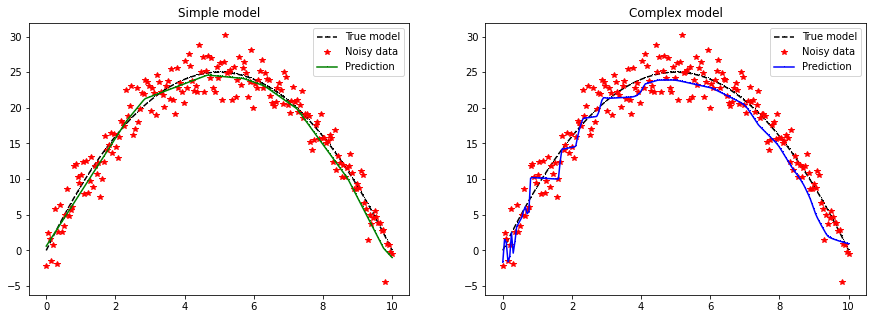

In [ ]:
# Compute at the predicted values
pred_y_simple = MyModel_simple.predict(obs_x)
pred_y_complex = MyModel_complex.predict(obs_x)


# Plot the results graphically
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax1.plot(obs_x, true_y, 'k--,', label="True model")
ax1.plot(obs_x, obs_y, 'r*', label="Noisy data")
ax1.plot(obs_x, pred_y_simple, 'g-,', label="Prediction")
ax1.set_title("Simple model")
ax1.legend()

ax2.plot(obs_x, true_y, 'k--,', label="True model")
ax2.plot(obs_x, obs_y, 'r*', label="Noisy data")
ax2.plot(obs_x, pred_y_complex, 'b-,', label="Prediction")
ax2.set_title("Complex model")
ax2.legend()

If we look at the plots above, the complex model exhibits more irregular pattern as if it is trying to fit the noises rather than the fundamental mechanism of the data generation. It is a symptom of overfitting.


---



# Testing set and validation set

A more "scientific" (rather than graphical) approach to detect overfitting is to break the available data into the training set and validation (or testing) set. Then we train the model using the training set only, but look at the performance of the model using the validation set.

The first step is to split our data into the two sets. This can be achieved by the function "train_test_split" from the "sklearn" library. In the example below, we spilt the data half-half. But in practice the proportion of data used for training is usually much larger (e.g. 70% of all data) especially if we have many more data points.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(obs_x, obs_y, test_size=0.5, random_state=123) #fix the "random_state" to ensure same random split outcomes every time for reproducibility

Now we define, compile and train our models again. Importantly, **only the training set (x_train, y_train) are passed to the "fit" command**.

In [ ]:
MyModel_simple = tf.keras.models.Sequential()
MyModel_simple.add(tf.keras.layers.Dense(50, activation="relu", input_shape=(1,)))
MyModel_simple.add(tf.keras.layers.Dense(50, activation="relu"))
MyModel_simple.add(tf.keras.layers.Dense(1, activation="linear"))

MyModel_complex = tf.keras.models.Sequential()
MyModel_complex.add(tf.keras.layers.Dense(1000, activation="relu", input_shape=(1,)))
for i in range(5):
    MyModel_complex.add(tf.keras.layers.Dense(1000, activation="relu"))
MyModel_complex.add(tf.keras.layers.Dense(1, activation="linear"))

MyModel_simple.compile(loss="mean_squared_error")
MyModel_simple.fit(x_train, y_train, epochs=1000, verbose=0)

MyModel_complex.compile(loss="mean_squared_error")
MyModel_complex.fit(x_train, y_train, epochs=1000, verbose=0)

Now we can compute the training loss and validation loss associated with the two fitted models.

In [ ]:
train_loss_simple = MyModel_simple.evaluate(x_train, y_train, verbose=0)
train_loss_complex = MyModel_complex.evaluate(x_train, y_train, verbose=0)
test_loss_simple = MyModel_simple.evaluate(x_test, y_test, verbose=0)
test_loss_complex = MyModel_complex.evaluate(x_test, y_test, verbose=0)

print("Training loss of simple model: ", train_loss_simple)
print("Training loss of complex model: ", train_loss_complex)

print("Validation loss of simple model: ", test_loss_simple)
print("Validation loss of complex model: ", test_loss_complex)

Training loss of simple model:  3.9134528636932373
Training loss of complex model:  3.2570433616638184
Validation loss of simple model:  5.105062007904053
Validation loss of complex model:  6.2698774337768555


From the prespective of training loss, the simple model is performing worse because it has larger value. But using validation loss, the simple model indeed performs better. This confirms our intuition that the complex model overfits the data such that its ability to generalise to unseen data is not so good.